# Analysis COSI Dataset: Text Classification with Camembert - fine tuning of the model + cleaning of the duplicates

**Data Description**:
- id user
- sex
- age
- code shop --> location shop in French department
- survey answer Q1
- survey answer Q2
- survey answer Q3
- HA: true/false


In [1]:
import numpy as np
import os as os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib import cm as CM
import random
import pandas as pd
color = sn.color_palette()
%matplotlib inline

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import geopandas as gpd
from shapely.geometry import Point
from geopy.geocoders import Nominatim
import time
import missingno as msno
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from summarizer import Summarizer
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# READING DATA

In [8]:
##############
#READING DATA#
##############
# COSI Q1 
df_Q1 = pd.read_excel('C:\\Users\\mcampi\\Desktop\\Postdoc_Pasteur\\Perrine\\data\\Cosi_Labelled\\COSI_LABELS.xlsx', sheet_name=0)
df_Q2 = pd.read_excel('C:\\Users\\mcampi\\Desktop\\Postdoc_Pasteur\\Perrine\\data\\Cosi_Labelled\\COSI_LABELS.xlsx', sheet_name=1)
df_Q3 = pd.read_excel('C:\\Users\\mcampi\\Desktop\\Postdoc_Pasteur\\Perrine\\data\\Cosi_Labelled\\COSI_LABELS.xlsx', sheet_name=2)

# Question 1

<Axes: >

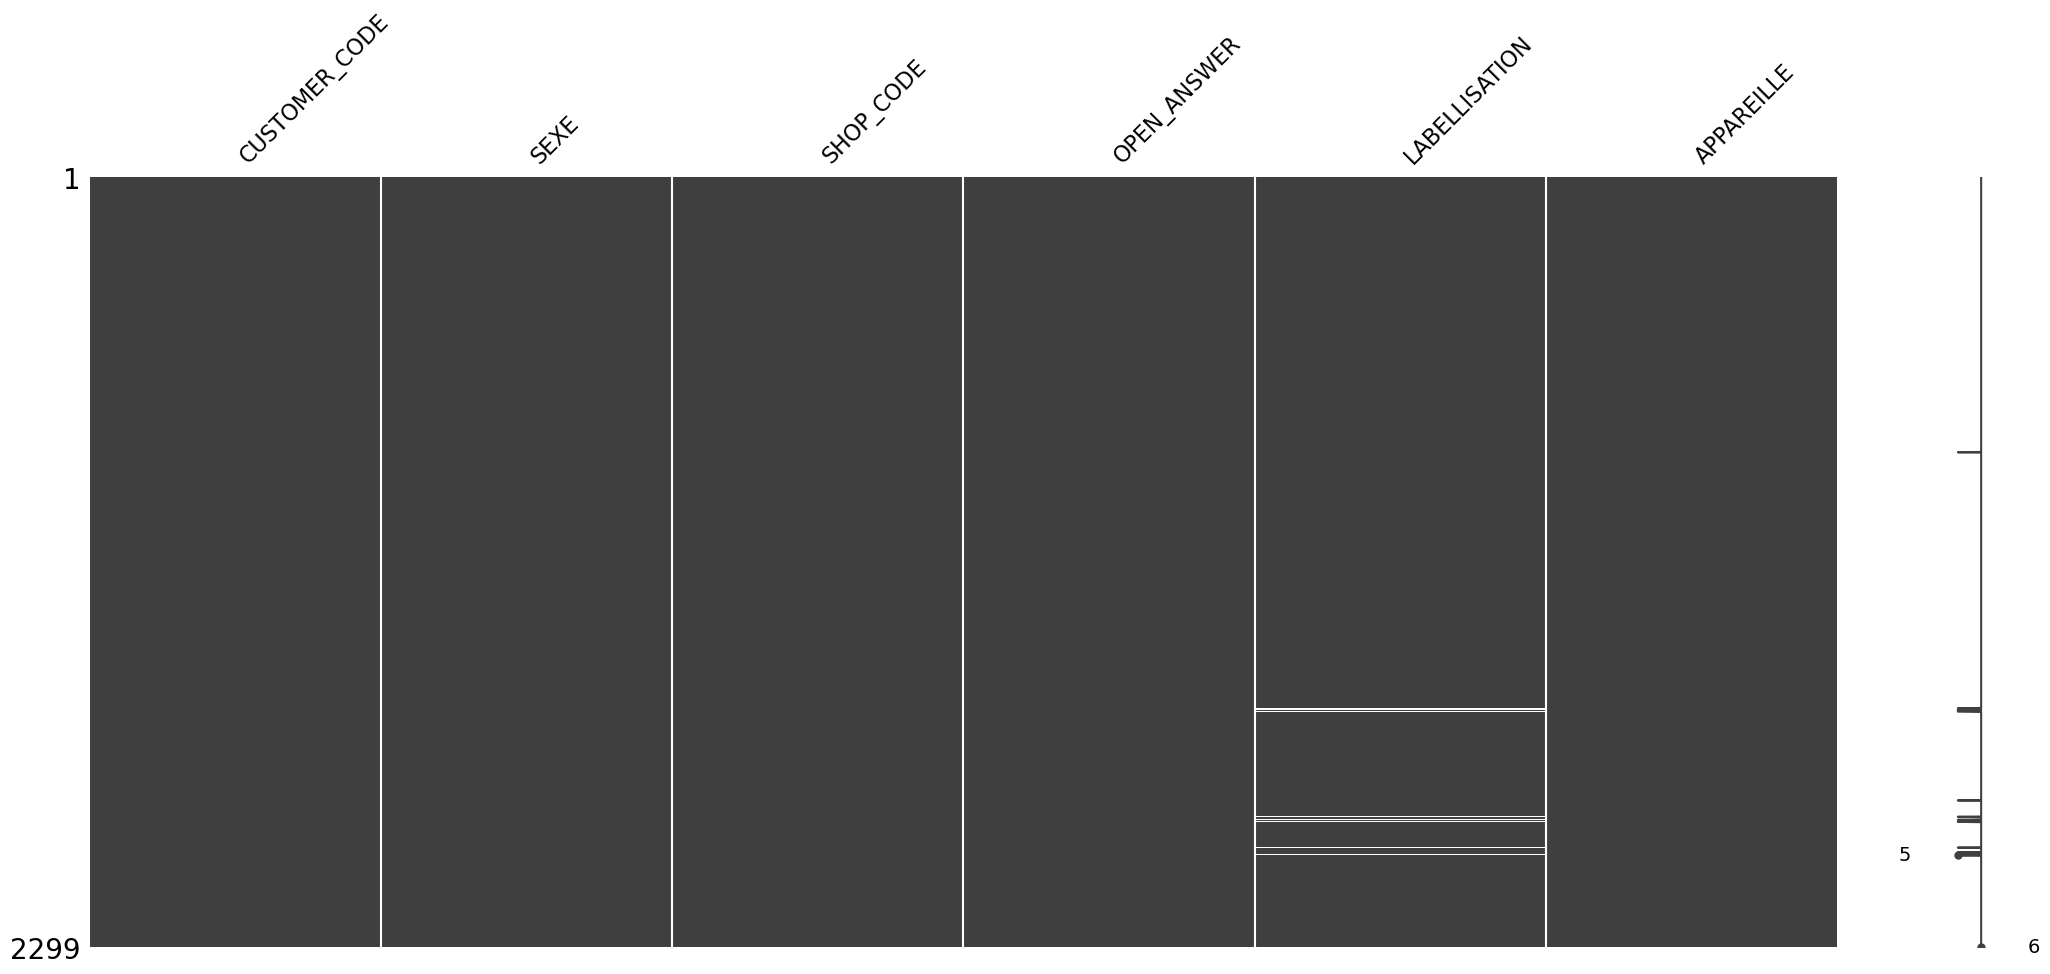

In [9]:
msno.matrix(df_Q1)

In [10]:
missing_percent_q1 = df_Q1.isna().mean() * 100  # Returns a Series with percentages of missing values
missing_percent_q1

CUSTOMER_CODE    0.000000
SEXE             0.000000
SHOP_CODE        0.000000
OPEN_ANSWER      0.000000
LABELLISATION    0.739452
APPAREILLE       0.000000
dtype: float64

In [11]:
df_Q1 = df_Q1.dropna()
df_Q1.isna().mean() * 100 

CUSTOMER_CODE    0.0
SEXE             0.0
SHOP_CODE        0.0
OPEN_ANSWER      0.0
LABELLISATION    0.0
APPAREILLE       0.0
dtype: float64

## Plots for Data Analysis

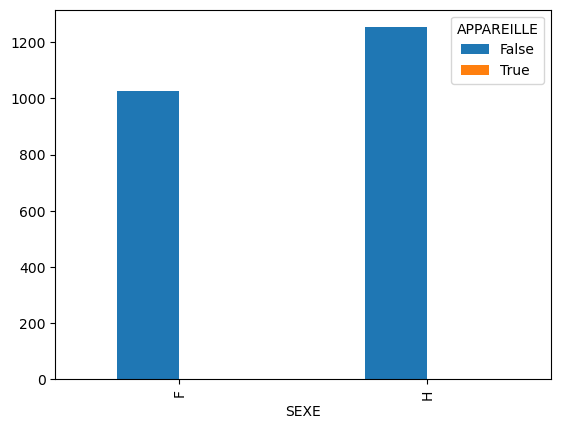

In [12]:
df_q1_counts = df_Q1.groupby(['SEXE', 'APPAREILLE']).size().reset_index(name='Count')

pivot_dfq1_counts = df_q1_counts.pivot(index='SEXE', columns='APPAREILLE', values='Count')
pivot_dfq1_counts.plot(kind='bar', stacked=False)
plt.show()

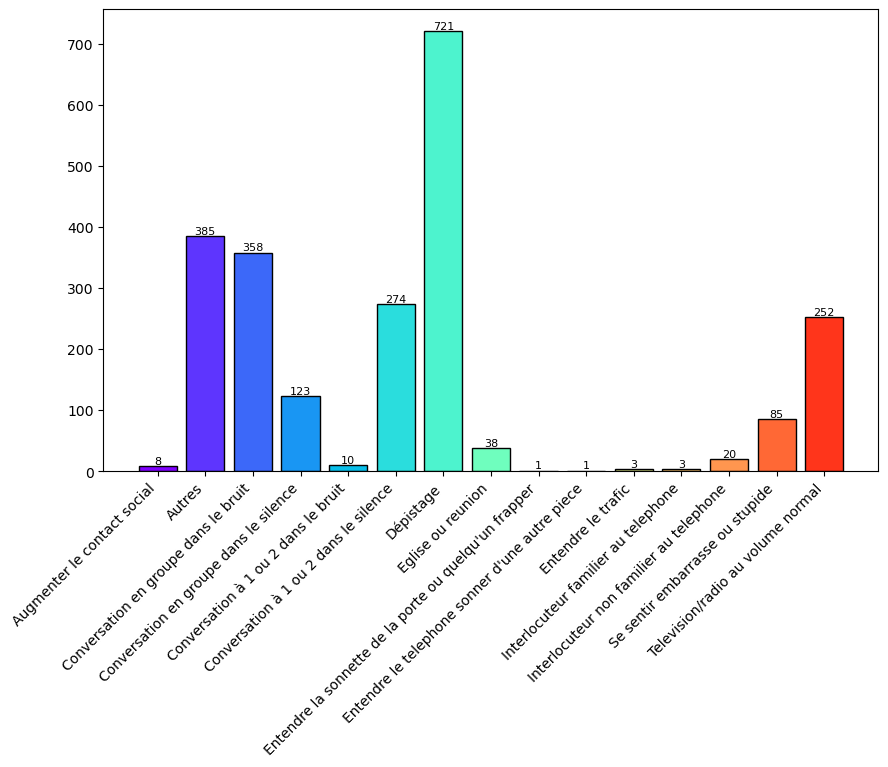

In [13]:
df_q1_labels_count = df_Q1.groupby(['LABELLISATION']).size().reset_index(name='Count')

plt.figure(figsize=(10, 6))

bars = plt.bar(df_q1_labels_count['LABELLISATION'], df_q1_labels_count['Count'], 
               width=0.8, edgecolor='black',
               color=plt.cm.rainbow(df_q1_labels_count.index / len(df_q1_labels_count)))
plt.xticks(rotation=45, ha='right')

# Add count annotations on each bar
for i, count in enumerate(df_q1_labels_count['Count']):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=8)

plt.show()

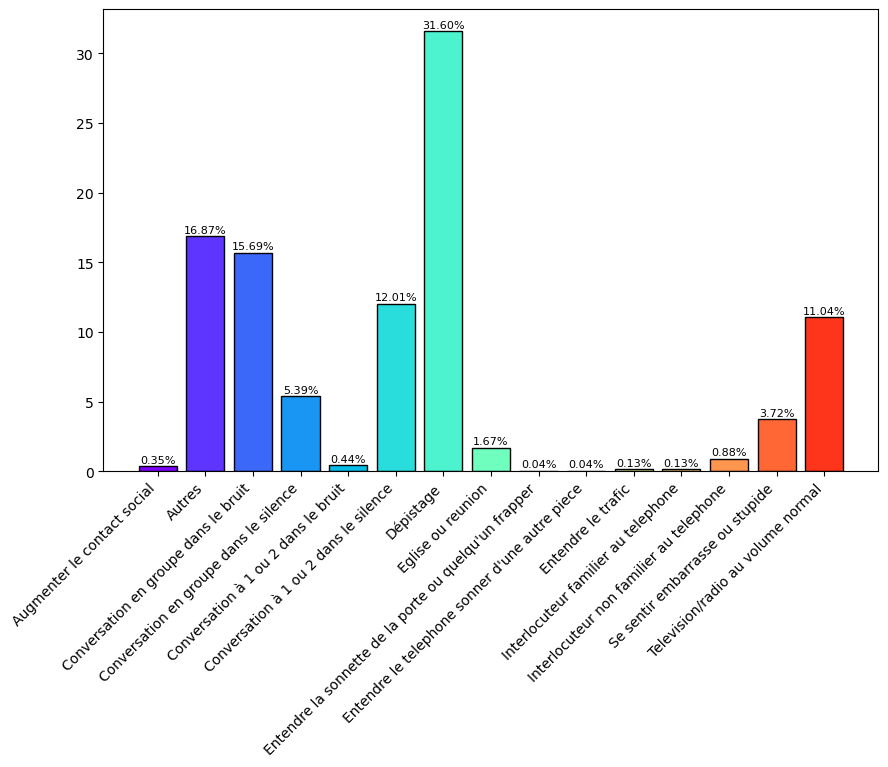

In [14]:
df_q1_labels_percentage = df_Q1.groupby(['LABELLISATION']).size() / len(df_Q1) * 100
df_q1_labels_percentage = df_q1_labels_percentage.reset_index(name='Percentage')

plt.figure(figsize=(10, 6))

bars = plt.bar(df_q1_labels_percentage['LABELLISATION'], df_q1_labels_percentage['Percentage'], 
               width=0.8, edgecolor='black',
               color=plt.cm.rainbow(df_q1_labels_percentage.index / len(df_q1_labels_percentage)))
plt.xticks(rotation=45, ha='right')

# Add percentage annotations on each bar
for i, percentage in enumerate(df_q1_labels_percentage['Percentage']):
    plt.text(i, percentage + 0.1, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8)

plt.show()

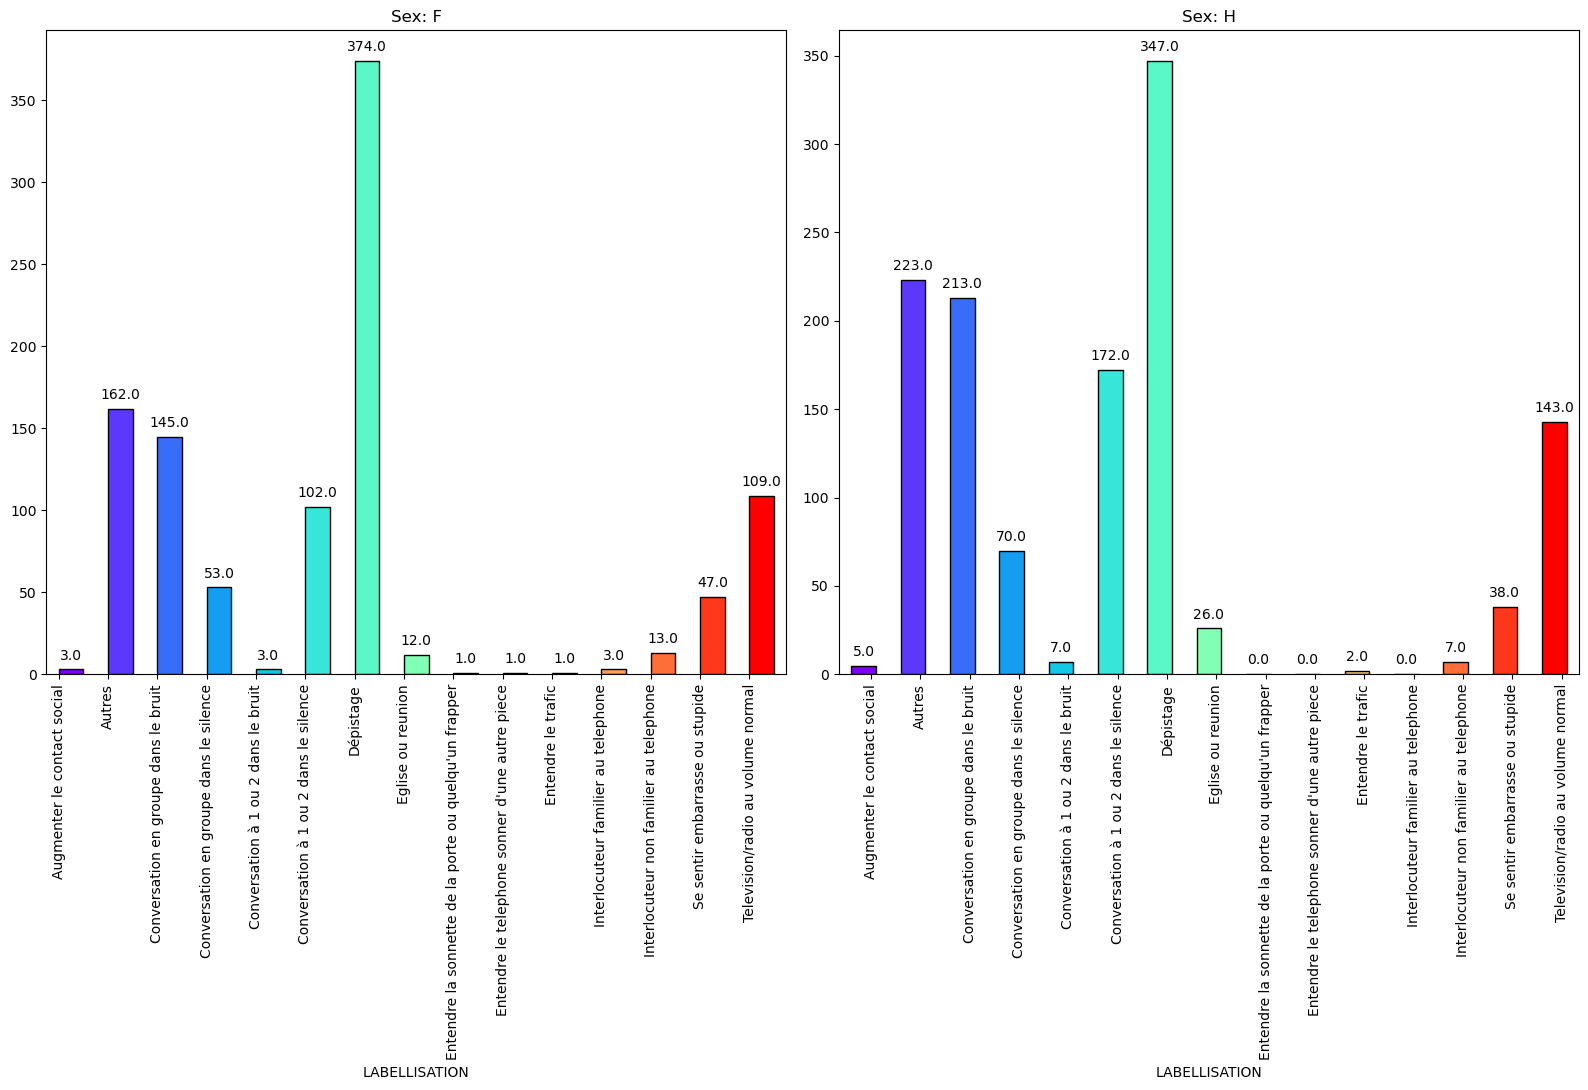

In [15]:
df_q1_labels_count2 = df_Q1.groupby(['SEXE', 'LABELLISATION']).size().reset_index(name='Count')

pivot_dfq1_counts2 = df_q1_labels_count2.pivot(index='SEXE', columns='LABELLISATION', values='Count')

colors = plt.cm.rainbow(np.linspace(0, 1, pivot_dfq1_counts2.shape[1]))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 11))

for i, (sex, data) in enumerate(pivot_dfq1_counts2.iterrows()):
    ax = axes[i]
    data.plot(kind='bar', stacked=False, color=colors, ax=ax, position=i*0.8, edgecolor='black')
    ax.set_title(f'Sex: {sex}')

    # Add count annotations on each bar
    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

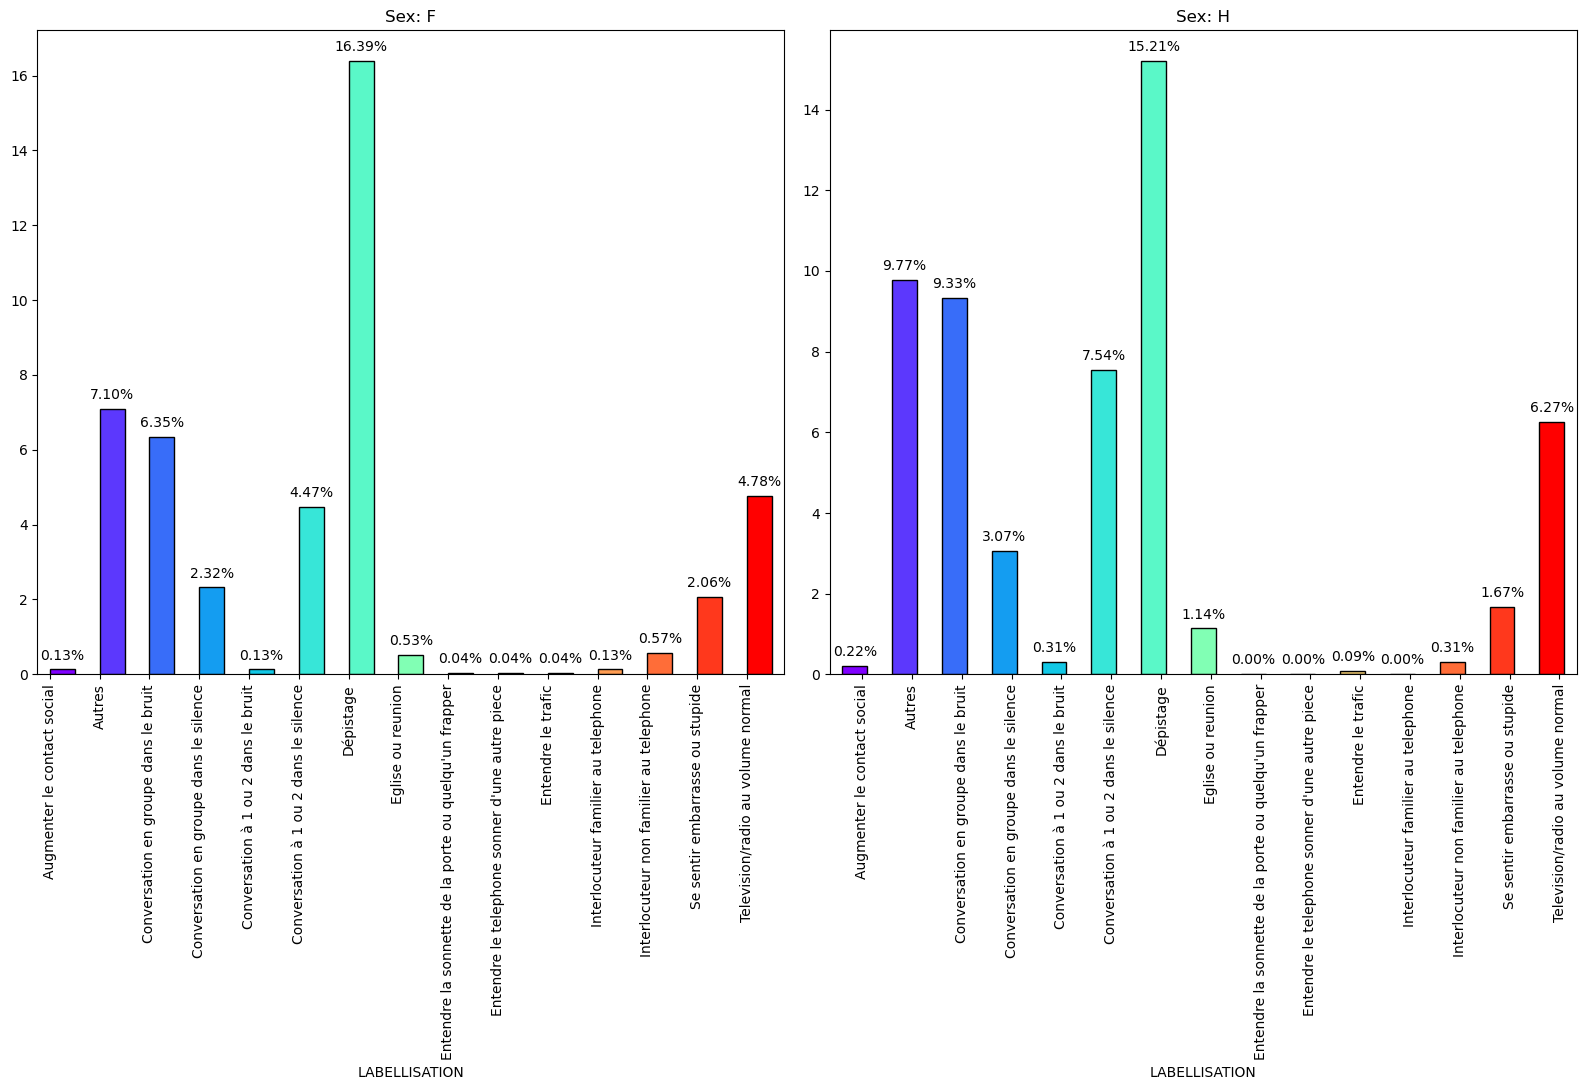

In [16]:
df_q1_labels_percentage2 = df_Q1.groupby(['SEXE', 'LABELLISATION']).size() / len(df_Q1) * 100
df_q1_labels_percentage2 = df_q1_labels_percentage2.reset_index(name='Percentage')

# Pivot the DataFrame
pivot_dfq1_percentages2 = df_q1_labels_percentage2.pivot(index='SEXE', columns='LABELLISATION', values='Percentage')

colors = plt.cm.rainbow(np.linspace(0, 1, pivot_dfq1_percentages2.shape[1]))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 11))

for i, (sex, data) in enumerate(pivot_dfq1_percentages2.iterrows()):
    ax = axes[i]
    data.plot(kind='bar', stacked=False, color=colors, ax=ax, position=i*0.8, edgecolor='black')
    ax.set_title(f'Sex: {sex}')

    # Add percentage annotations on each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

# Question 2

<Axes: >

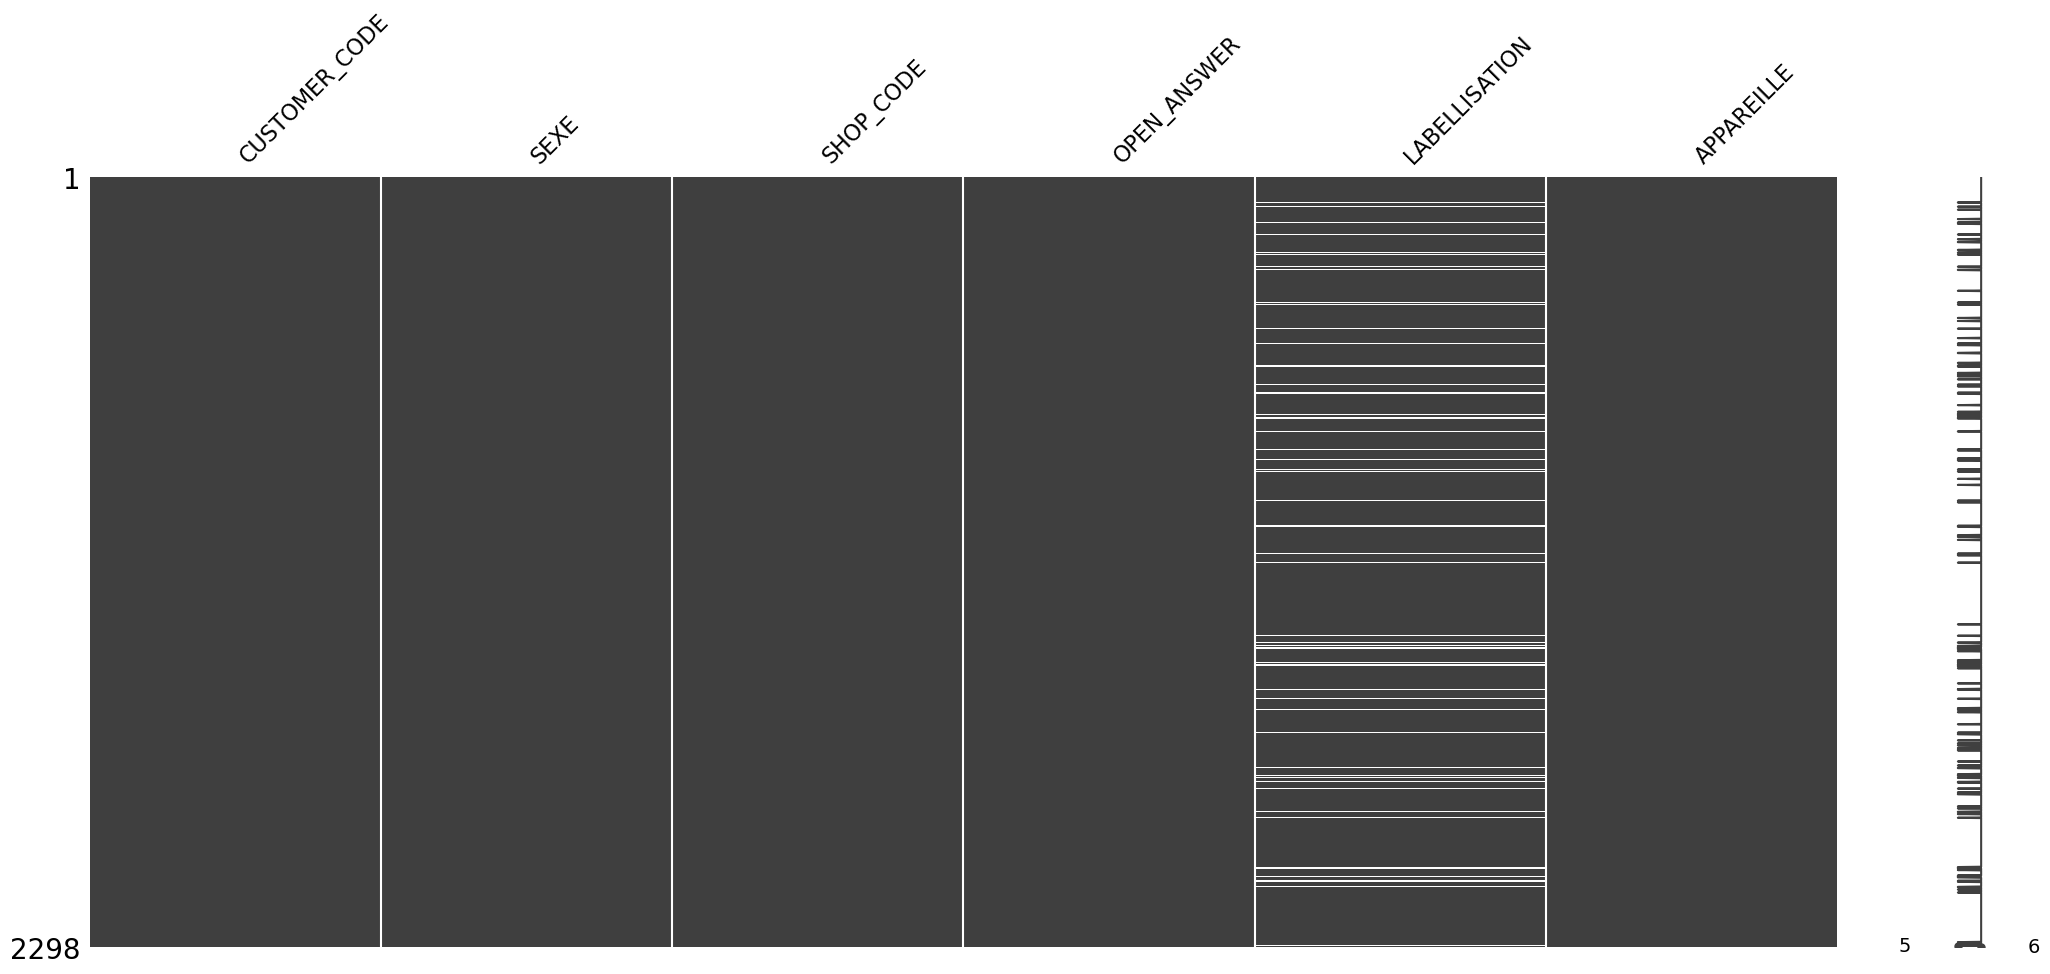

In [17]:
msno.matrix(df_Q2)

In [18]:
missing_percent_q2 = df_Q2.isna().mean() * 100  # Returns a Series with percentages of missing values
missing_percent_q2

CUSTOMER_CODE    0.000000
SEXE             0.000000
SHOP_CODE        0.000000
OPEN_ANSWER      0.000000
LABELLISATION    6.570931
APPAREILLE       0.000000
dtype: float64

In [19]:
df_Q2 = df_Q2.dropna()
df_Q2.isna().mean() * 100 

CUSTOMER_CODE    0.0
SEXE             0.0
SHOP_CODE        0.0
OPEN_ANSWER      0.0
LABELLISATION    0.0
APPAREILLE       0.0
dtype: float64

## Plots for Data Analysis

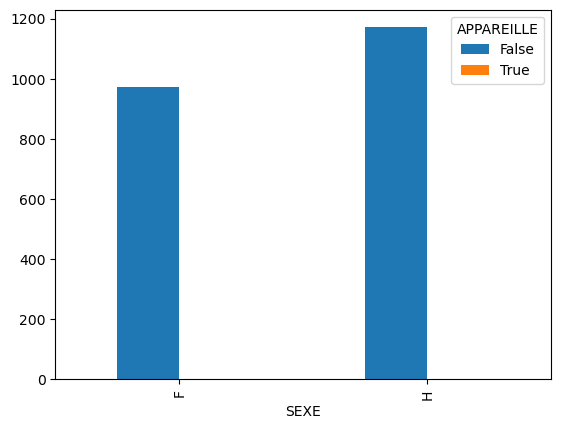

In [20]:
df_q2_counts = df_Q2.groupby(['SEXE', 'APPAREILLE']).size().reset_index(name='Count')

pivot_dfq2_counts = df_q2_counts.pivot(index='SEXE', columns='APPAREILLE', values='Count')
pivot_dfq2_counts.plot(kind='bar', stacked=False)
plt.show()

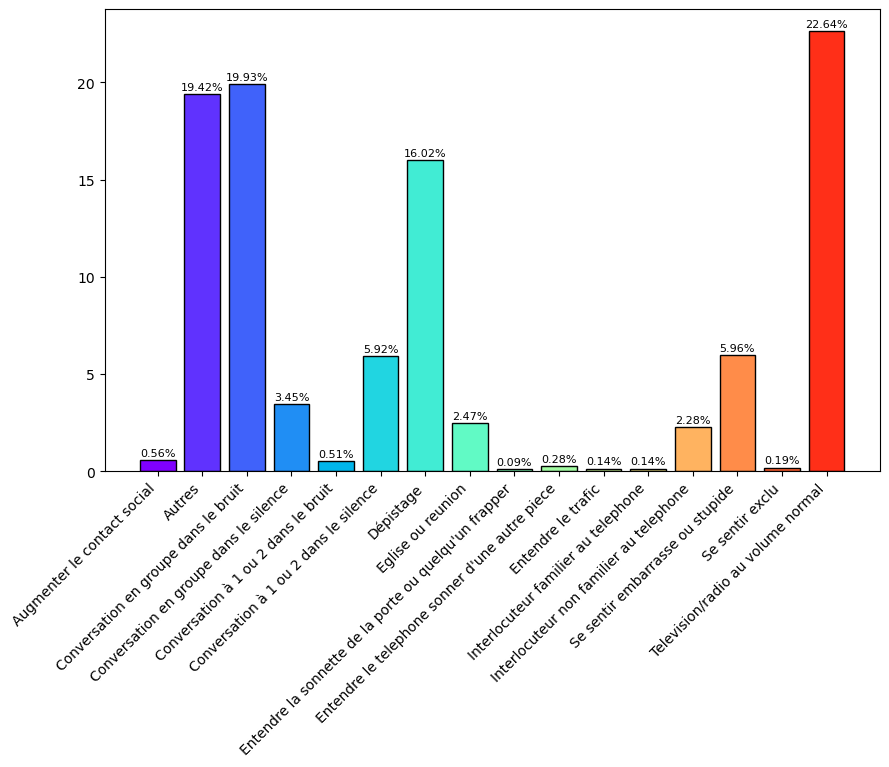

In [21]:
df_q2_labels_percentage = df_Q2.groupby(['LABELLISATION']).size() / len(df_Q2) * 100
df_q2_labels_percentage = df_q2_labels_percentage.reset_index(name='Percentage')

plt.figure(figsize=(10, 6))

bars = plt.bar(df_q2_labels_percentage['LABELLISATION'], df_q2_labels_percentage['Percentage'], 
               width=0.8, edgecolor='black',
               color=plt.cm.rainbow(df_q2_labels_percentage.index / len(df_q2_labels_percentage)))
plt.xticks(rotation=45, ha='right')

# Add percentage annotations on each bar
for i, percentage in enumerate(df_q2_labels_percentage['Percentage']):
    plt.text(i, percentage + 0.1, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8)

plt.show()

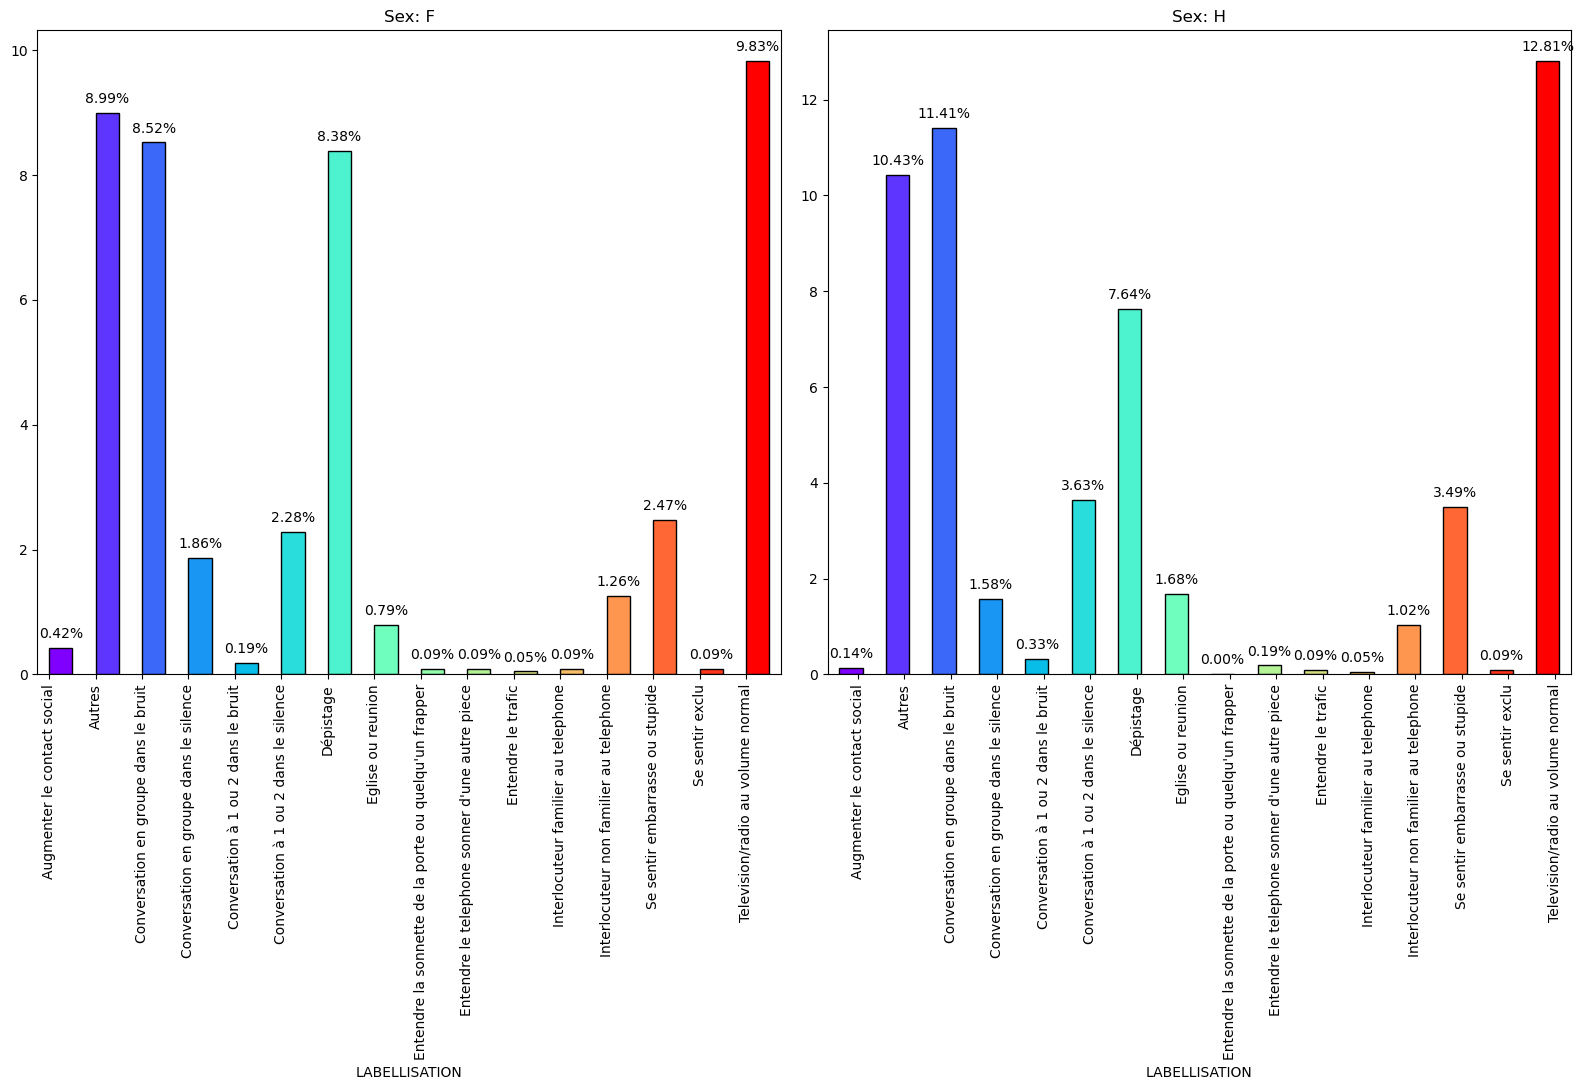

In [22]:
df_q2_labels_percentage2 = df_Q2.groupby(['SEXE', 'LABELLISATION']).size() / len(df_Q2) * 100
df_q2_labels_percentage2 = df_q2_labels_percentage2.reset_index(name='Percentage')

# Pivot the DataFrame
pivot_dfq2_percentages2 = df_q2_labels_percentage2.pivot(index='SEXE', columns='LABELLISATION', values='Percentage')

colors = plt.cm.rainbow(np.linspace(0, 1, pivot_dfq2_percentages2.shape[1]))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 11))

for i, (sex, data) in enumerate(pivot_dfq2_percentages2.iterrows()):
    ax = axes[i]
    data.plot(kind='bar', stacked=False, color=colors, ax=ax, position=i*0.8, edgecolor='black')
    ax.set_title(f'Sex: {sex}')

    # Add percentage annotations on each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

# Question 3

<Axes: >

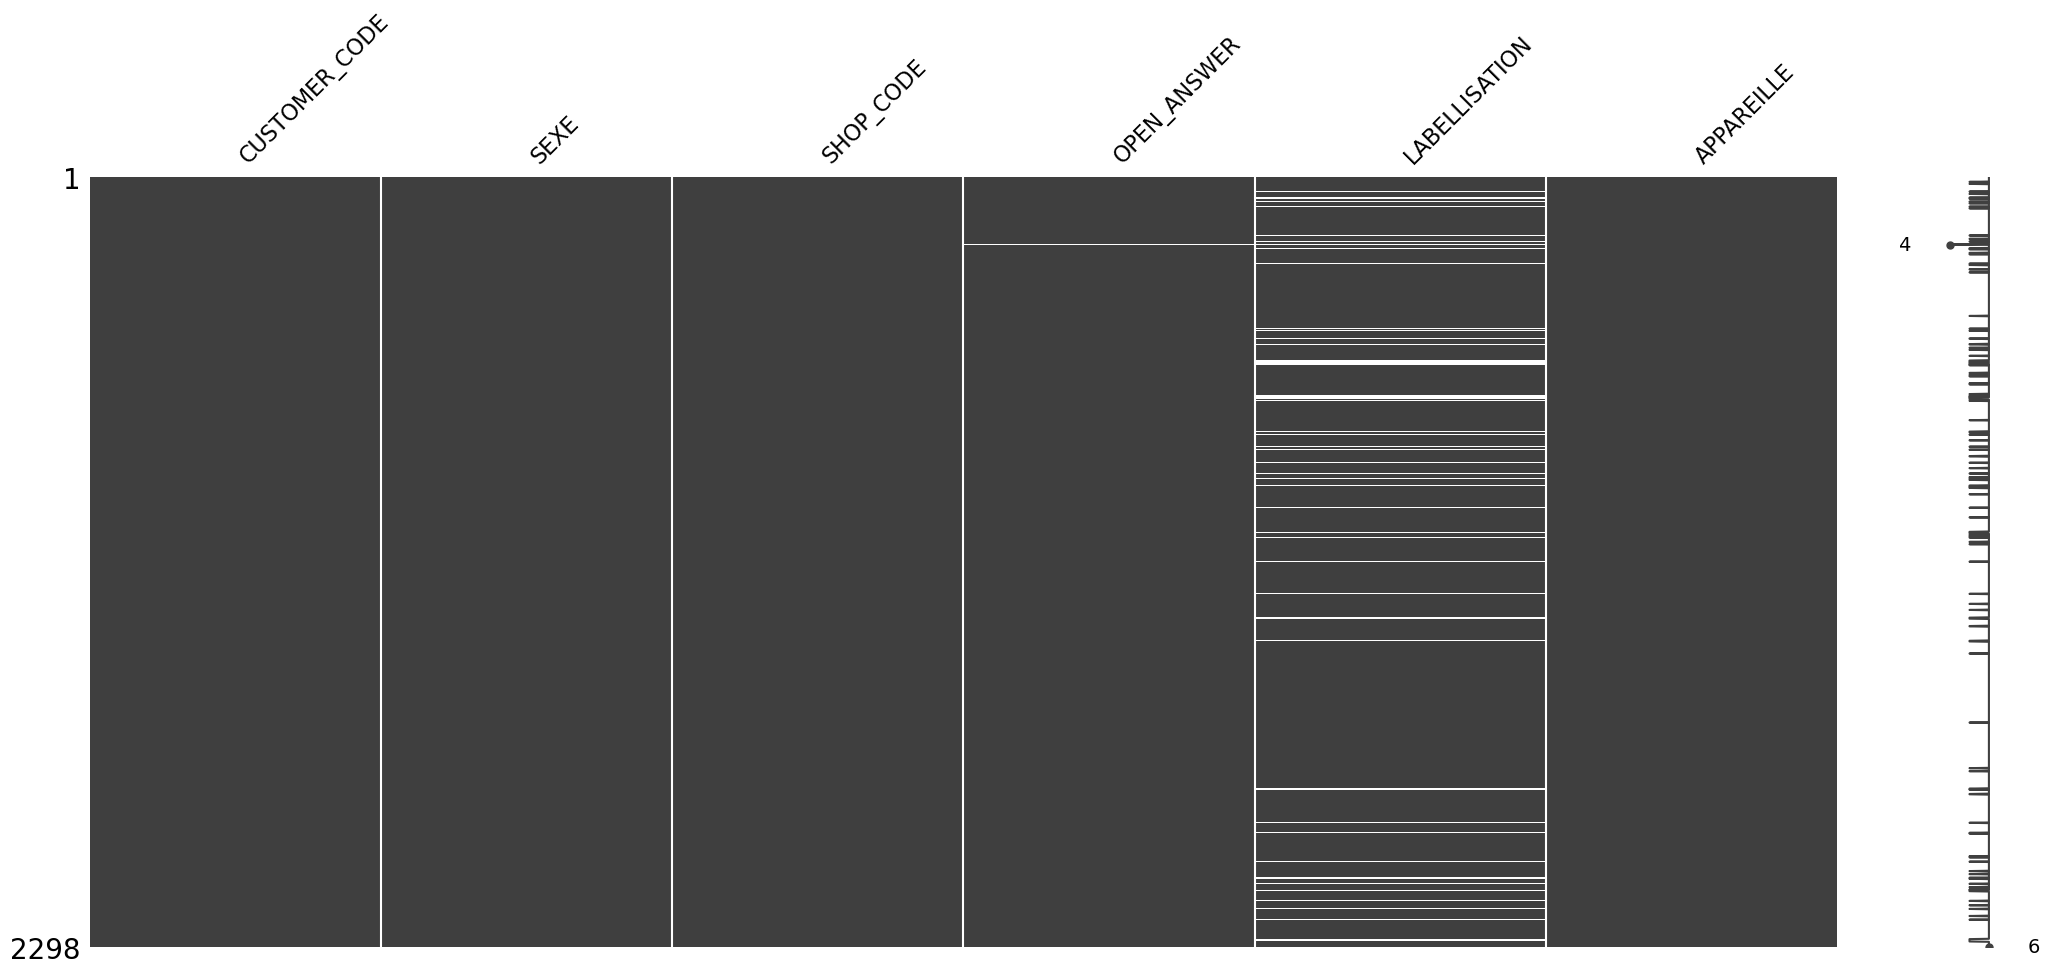

In [23]:
msno.matrix(df_Q3)

In [24]:
missing_percent_q3 = df_Q3.isna().mean() * 100  # Returns a Series with percentages of missing values
missing_percent_q3

CUSTOMER_CODE    0.000000
SEXE             0.000000
SHOP_CODE        0.000000
OPEN_ANSWER      0.043516
LABELLISATION    6.266319
APPAREILLE       0.000000
dtype: float64

In [25]:
df_Q3 = df_Q3.dropna()
df_Q3.isna().mean() * 100 

CUSTOMER_CODE    0.0
SEXE             0.0
SHOP_CODE        0.0
OPEN_ANSWER      0.0
LABELLISATION    0.0
APPAREILLE       0.0
dtype: float64

## Plots for Data Analysis

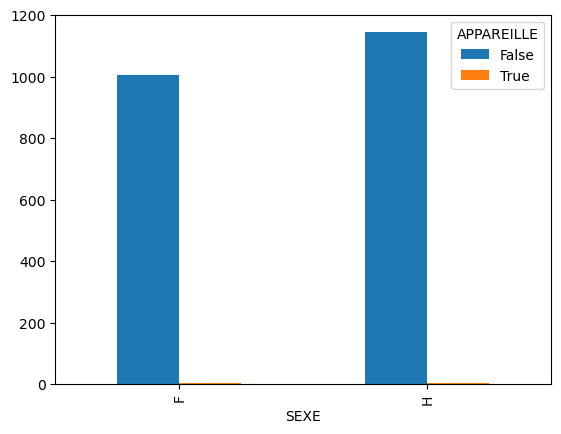

In [26]:
df_q3_counts = df_Q3.groupby(['SEXE', 'APPAREILLE']).size().reset_index(name='Count')

pivot_dfq3_counts = df_q3_counts.pivot(index='SEXE', columns='APPAREILLE', values='Count')
pivot_dfq3_counts.plot(kind='bar', stacked=False)
plt.show()

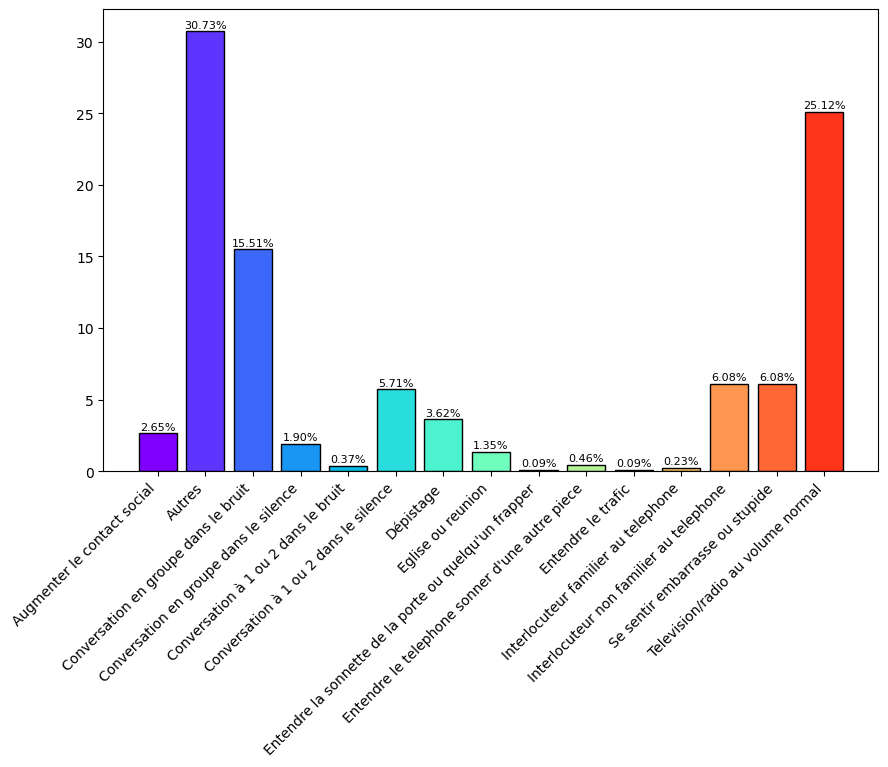

In [27]:
df_q3_labels_percentage = df_Q3.groupby(['LABELLISATION']).size() / len(df_Q3) * 100
df_q3_labels_percentage = df_q3_labels_percentage.reset_index(name='Percentage')

plt.figure(figsize=(10, 6))

bars = plt.bar(df_q3_labels_percentage['LABELLISATION'], df_q3_labels_percentage['Percentage'], 
               width=0.8, edgecolor='black',
               color=plt.cm.rainbow(df_q3_labels_percentage.index / len(df_q3_labels_percentage)))
plt.xticks(rotation=45, ha='right')

# Add percentage annotations on each bar
for i, percentage in enumerate(df_q3_labels_percentage['Percentage']):
    plt.text(i, percentage + 0.1, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8)

plt.show()

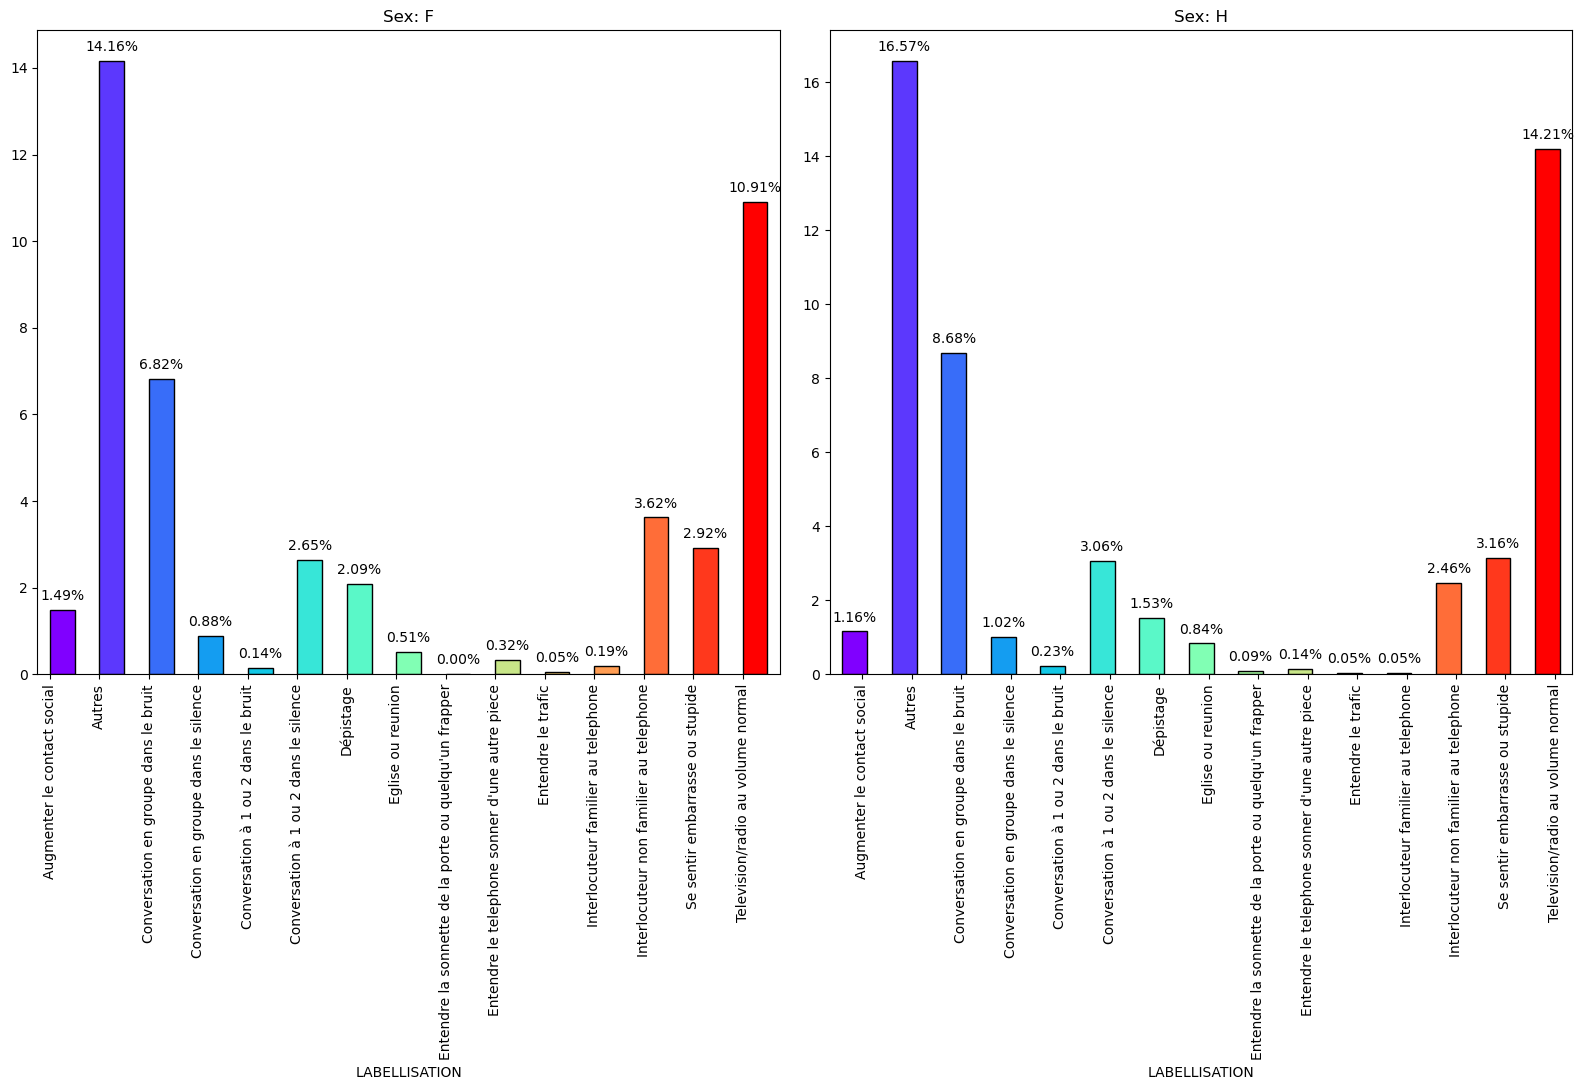

In [28]:
df_q3_labels_percentage2 = df_Q3.groupby(['SEXE', 'LABELLISATION']).size() / len(df_Q3) * 100
df_q3_labels_percentage2 = df_q3_labels_percentage2.reset_index(name='Percentage')

# Pivot the DataFrame
pivot_dfq3_percentages2 = df_q3_labels_percentage2.pivot(index='SEXE', columns='LABELLISATION', values='Percentage')

colors = plt.cm.rainbow(np.linspace(0, 1, pivot_dfq3_percentages2.shape[1]))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 11))

for i, (sex, data) in enumerate(pivot_dfq3_percentages2.iterrows()):
    ax = axes[i]
    data.plot(kind='bar', stacked=False, color=colors, ax=ax, position=i*0.8, edgecolor='black')
    ax.set_title(f'Sex: {sex}')

    # Add percentage annotations on each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

# Q1 - Q2 - Q3 together

In [29]:
df_Q = pd.concat([df_Q1, df_Q2, df_Q3], ignore_index=True)

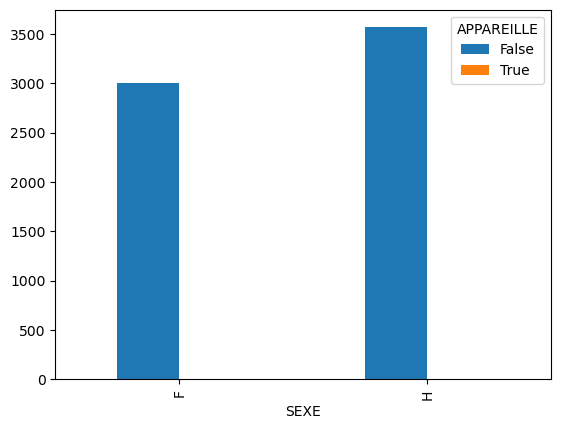

In [30]:
df_counts = df_Q.groupby(['SEXE', 'APPAREILLE']).size().reset_index(name='Count')

pivot_df_counts = df_counts.pivot(index='SEXE', columns='APPAREILLE', values='Count')
pivot_df_counts.plot(kind='bar', stacked=False)
plt.show()

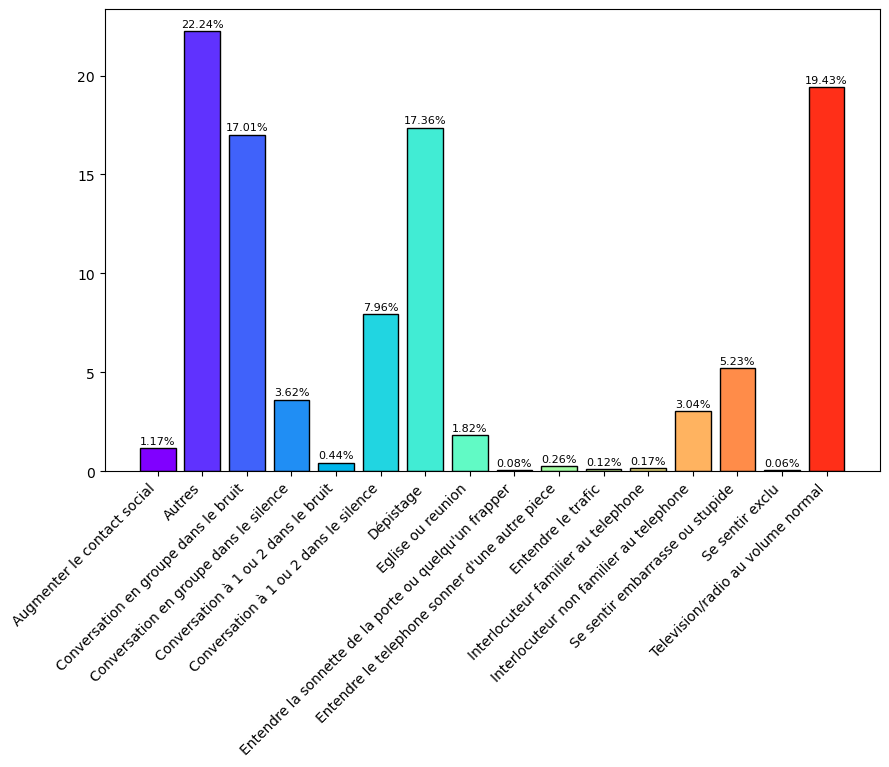

In [31]:
df_labels_percentage = df_Q.groupby(['LABELLISATION']).size() / len(df_Q) * 100
df_labels_percentage = df_labels_percentage.reset_index(name='Percentage')

plt.figure(figsize=(10, 6))

bars = plt.bar(df_labels_percentage['LABELLISATION'], df_labels_percentage['Percentage'], 
               width=0.8, edgecolor='black',
               color=plt.cm.rainbow(df_labels_percentage.index / len(df_labels_percentage)))
plt.xticks(rotation=45, ha='right')

# Add percentage annotations on each bar
for i, percentage in enumerate(df_labels_percentage['Percentage']):
    plt.text(i, percentage + 0.1, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8)

plt.show()

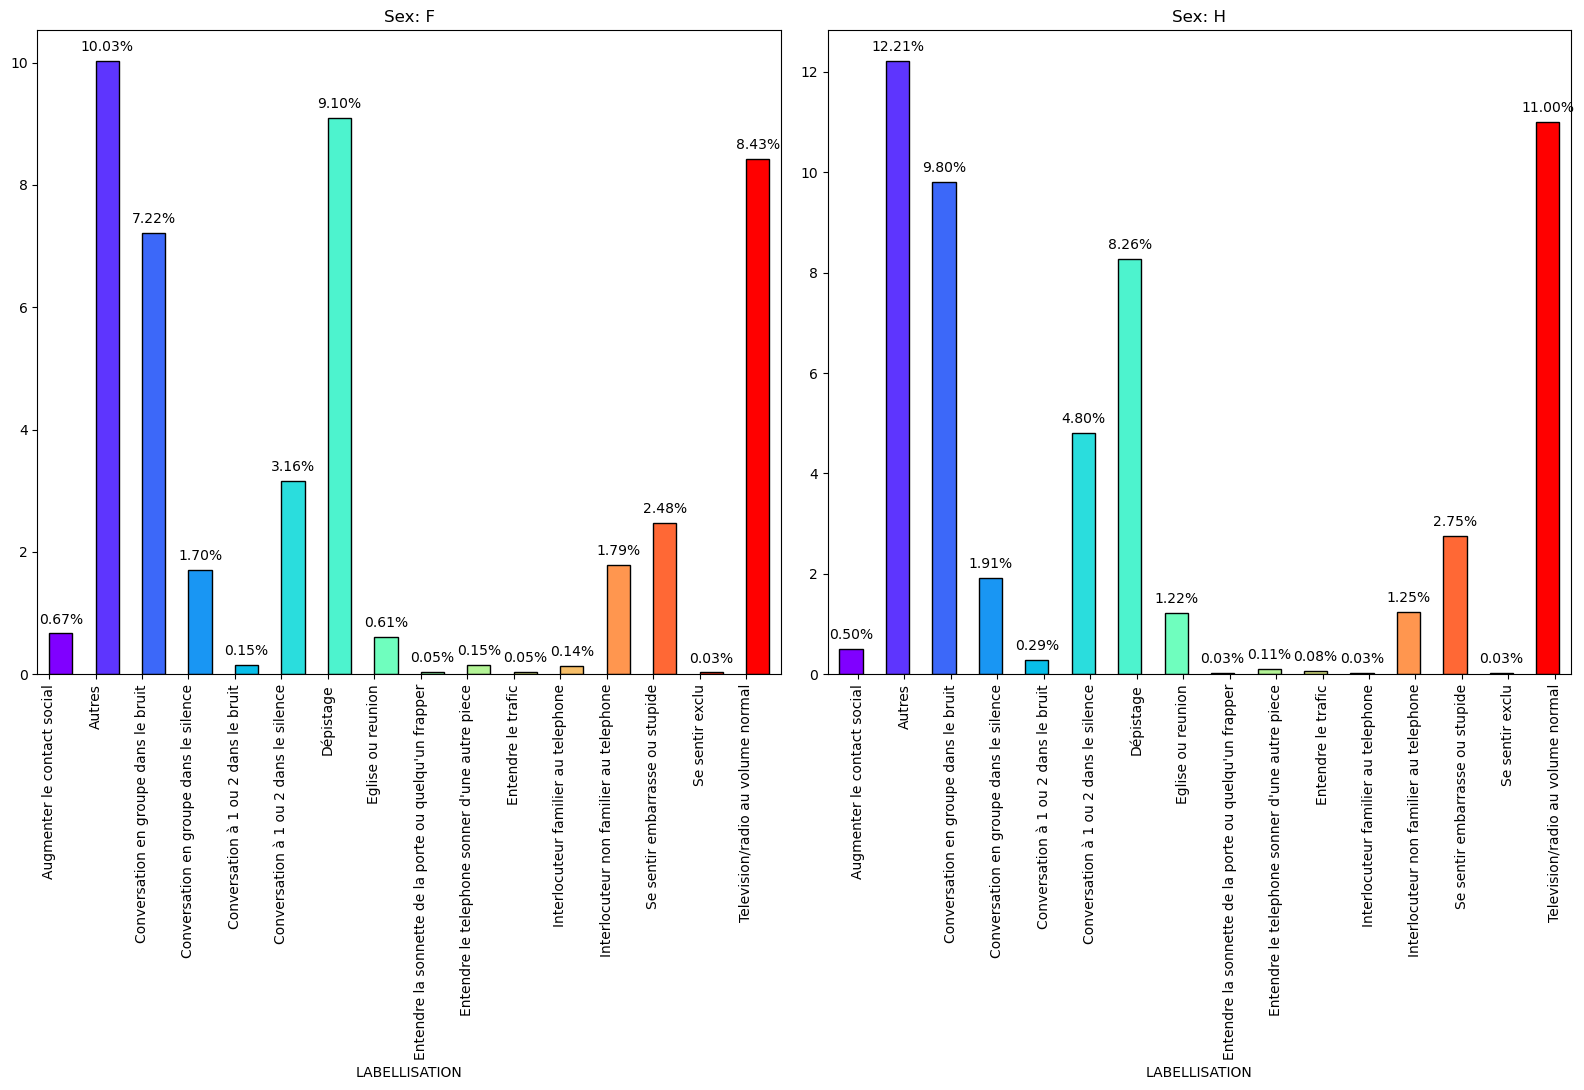

In [32]:
df_labels_percentage2 = df_Q.groupby(['SEXE', 'LABELLISATION']).size() / len(df_Q) * 100
df_labels_percentage2 = df_labels_percentage2.reset_index(name='Percentage')

# Pivot the DataFrame
pivot_df_percentages2 = df_labels_percentage2.pivot(index='SEXE', columns='LABELLISATION', values='Percentage')

colors = plt.cm.rainbow(np.linspace(0, 1, pivot_df_percentages2.shape[1]))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 11))

for i, (sex, data) in enumerate(pivot_df_percentages2.iterrows()):
    ax = axes[i]
    data.plot(kind='bar', stacked=False, color=colors, ax=ax, position=i*0.8, edgecolor='black')
    ax.set_title(f'Sex: {sex}')

    # Add percentage annotations on each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

# RTSNE with Camembert

In [33]:
from transformers import CamembertTokenizer, CamembertModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [34]:
# Load Camembert model and tokenizer
camembert_model = CamembertModel.from_pretrained("camembert-base")
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")


In [35]:
text_data = df_Q['OPEN_ANSWER']

In [36]:
# Tokenize and get embeddings
tokenized_texts = [tokenizer(text, return_tensors='pt', truncation=True, padding=True) for text in text_data]
embeddings = [camembert_model(**tokens)['last_hidden_state'].mean(dim=1).squeeze().detach().numpy() for tokens in tokenized_texts]


In [37]:
# Convert the list of embeddings into a NumPy array
embeddings_array = np.array(embeddings)

In [38]:
# Apply t-SNE on embeddings
tsne_embeddings = TSNE(n_components=2).fit_transform(embeddings_array)


c:\Users\mcampi\Anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning:

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "c:\Users\mcampi\Anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


In [39]:
# Convert t-SNE results to DataFrame for visualization
tsne_df = pd.DataFrame(tsne_embeddings, columns=['Dimension 1', 'Dimension 2'])
tsne_df['Text'] = text_data


In [40]:
tsne_df['Label'] = df_Q['LABELLISATION']

### TSNE no Labels

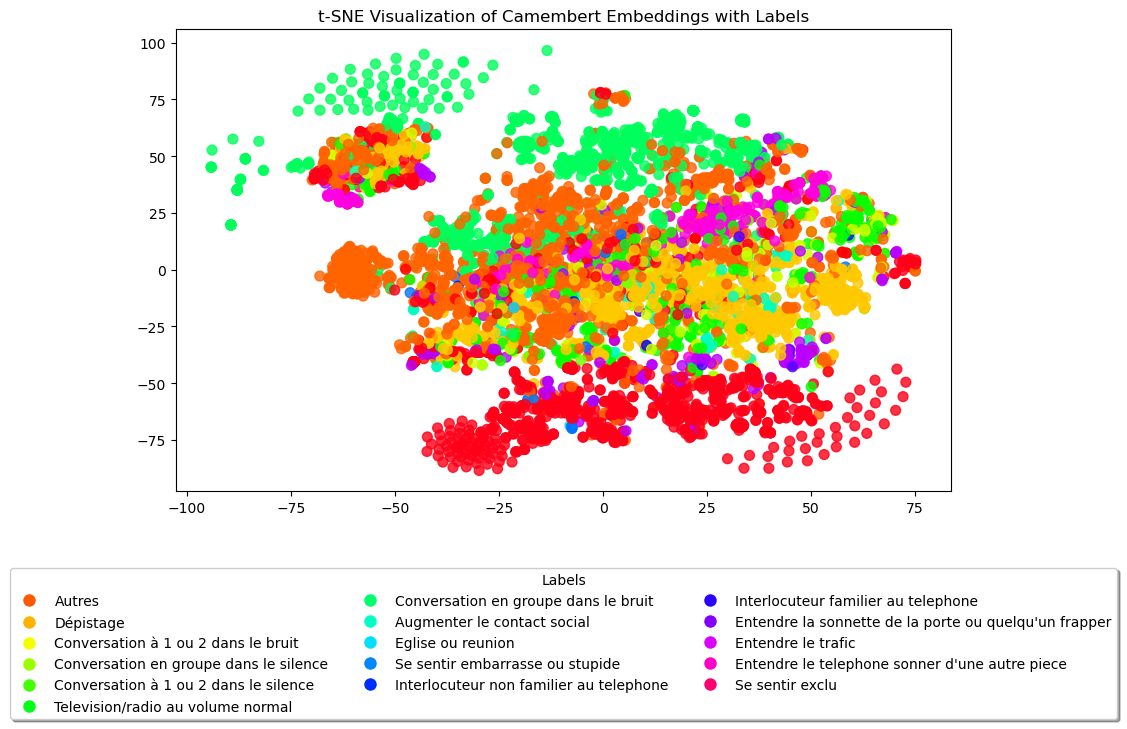

In [41]:
# Set up a categorical color palette
palette = sns.color_palette("hsv", len(tsne_df['Label'].unique()))

# Scatter plot with different colors for each label
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x='Dimension 1', y='Dimension 2', c=tsne_df['Label'].astype('category').cat.codes, cmap='hsv', data=tsne_df, s=50, alpha=0.8)

# Add text labels
#for i in range(len(tsne_df)):
#    plt.text(tsne_df['Dimension 1'][i], tsne_df['Dimension 2'][i], tsne_df['Text'][i], fontsize=8)

# Add legend at the bottom
legend_labels = tsne_df['Label'].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10, label=legend_labels[i]) for i in range(len(legend_labels))]
plt.legend(handles=legend_handles, title='Labels', bbox_to_anchor=(0.5, -0.15), loc='upper center', fancybox=True, shadow=True, ncol=3)

plt.title('t-SNE Visualization of Camembert Embeddings with Labels')
plt.show()

# CamemBERT

In [93]:
from transformers import AutoModelForSequenceClassification, CamembertForMaskedLM, AutoTokenizer, AutoConfig

In [94]:
camembert = CamembertForMaskedLM.from_pretrained('camembert-base')

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing CamembertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [95]:
camembert.roberta.embeddings

CamembertEmbeddings(
  (word_embeddings): Embedding(32005, 768, padding_idx=1)
  (position_embeddings): Embedding(514, 768, padding_idx=1)
  (token_type_embeddings): Embedding(1, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [96]:
def display_nb_params(model):
    param_size = 0
    param_count = 0
    for param in model.parameters():
        param_count += param.nelement()
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('Nombre de paramètres: {} | Poids du modèle: {:.2f}MB'.format(param_count, size_all_mb))

display_nb_params(camembert)

Nombre de paramètres: 110655493 | Poids du modèle: 422.13MB


# TEXT CLASSIFICATION

In [42]:
import pandas as pd
import torch
from tqdm import tqdm, trange
import numpy as np

In [43]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import CamembertTokenizer, CamembertForSequenceClassification

In [44]:
from transformers import AdamW

In [45]:
# Defining constants
epochs = 5
MAX_LEN = 128
batch_size = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [46]:
# Initialize CamemBERT tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base',do_lower_case=True)

In [47]:
# Creates list of texts and labels
text = df_Q['OPEN_ANSWER'].to_list()
labels = df_Q['LABELLISATION'].to_list()

In [48]:
#user tokenizer to convert sentences into tokenizer
input_ids  = [tokenizer.encode(sent,add_special_tokens=True,max_length=MAX_LEN) for sent in text]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [49]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [50]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]  
    attention_masks.append(seq_mask)

In [51]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks, random_state=42, test_size=0.1)

In [52]:
# Assuming you have a list of string labels
label_mapping = {'Autres': 0, 
                 'Dépistage': 1, 
                 'Conversation à 1 ou 2 dans le bruit': 2,
                 'Conversation en groupe dans le silence': 3, 
                 'Conversation à 1 ou 2 dans le silence': 4,
                 'Conversation à 1 ou 2 dans le bruit': 5,
                 'Television/radio au volume normal': 6, 
                 'Conversation en groupe dans le bruit': 7, 
                 'Augmenter le contact social': 8,
                 'Eglise ou reunion': 9, 
                 'Se sentir embarrasse ou stupide': 10,
                'Interlocuteur non familier au telephone': 11,
                'Interlocuteur familier au telephone': 12,
                 "Entendre la sonnette de la porte ou quelqu'un frapper": 13, 
                 'Entendre le trafic': 14,
                "Entendre le telephone sonner d'une autre piece": 15,
                'Se sentir exclu': 16}  # Define a mapping from string labels to numerical values

# Convert string labels to numerical values
train_labels_numeric = [label_mapping[label] for label in train_labels]
validation_labels_numeric = [label_mapping[label] for label in validation_labels]

# Convert lists to tensors
train_labels_tensor = torch.tensor(train_labels_numeric)
validation_labels_tensor = torch.tensor(validation_labels_numeric)

In [53]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = train_labels_tensor
validation_labels = validation_labels_tensor
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)


In [54]:
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [55]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=17)
model.to(device)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0): CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
     

##### PARAMETERS TO OPTIMIZE

In [56]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=10e-8)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

c:\Users\mcampi\Anaconda3\lib\site-packages\transformers\optimization.py:411: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



#### Training and evaluating our model

In [57]:
# Store our loss and accuracy for plotting if we want to visualize training evolution per epochs after the training process
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):  
    # Tracking variables for training
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the model
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # Get loss value
        loss = outputs[0]
        # Add it to train loss list
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
    
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    


    # Tracking variables for validation
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Validation of the model
    model.eval()
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs =  model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = outputs[:2]
    
        # Move logits and labels to CPU if GPU is used
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 1.5935527672664818


Epoch:  20%|██        | 1/5 [48:25<3:13:40, 2905.19s/it]

Validation Accuracy: 0.8482142857142857
Train loss: 0.6603037500076216


Epoch:  40%|████      | 2/5 [1:32:49<2:18:09, 2763.32s/it]

Validation Accuracy: 0.8735119047619048
Train loss: 0.4527375532509985


Epoch:  60%|██████    | 3/5 [2:19:53<1:33:01, 2790.99s/it]

Validation Accuracy: 0.8571428571428571
Train loss: 0.355836557299702


Epoch:  80%|████████  | 4/5 [3:04:36<45:48, 2748.52s/it]  

Validation Accuracy: 0.8645833333333334
Train loss: 0.2838820820207384


Epoch: 100%|██████████| 5/5 [3:52:37<00:00, 2791.54s/it]

Validation Accuracy: 0.8526785714285714


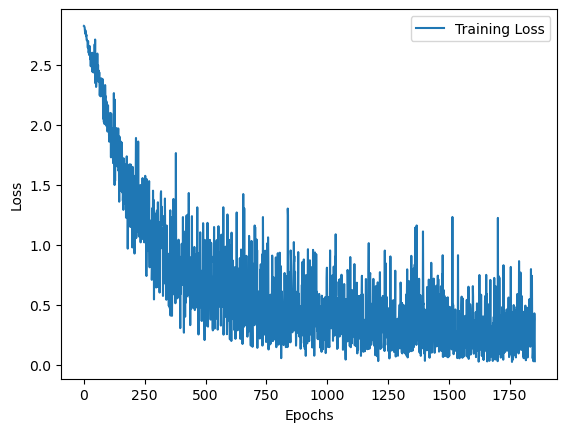

In [63]:
# Assuming train_loss_set and eval_accuracy_set are lists containing values over epochs
plt.plot(train_loss_set, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_loss_curve.png')
plt.show()

In [64]:
torch.save(model, 'full_model.pth')


## Test the model on an unseen texts

In [66]:
##############
#READING DATA#
##############
# COSI Q1 
df_test = pd.read_excel('C:\\Users\\mcampi\\Desktop\\Postdoc_Pasteur\\Perrine\\data\\Cosi_Labelled\\COSI_LABELS_test.xlsx', sheet_name=0)

In [68]:
comments = df_test['OPEN_ANSWER']

In [69]:
len(comments)

2001

In [70]:
# Encode the comments
tokenized_comments_ids = [tokenizer.encode(comment,add_special_tokens=True,max_length=MAX_LEN) for comment in comments]
# Pad the resulted encoded comments
tokenized_comments_ids = pad_sequences(tokenized_comments_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks 
attention_masks = []
for seq in tokenized_comments_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(tokenized_comments_ids)
prediction_masks = torch.tensor(attention_masks)

In [71]:
# Apply the finetuned model (Camembert)
flat_pred = []
with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs =  model(prediction_inputs.to(device),token_type_ids=None, attention_mask=prediction_masks.to(device))
    logits = outputs[0]
    logits = logits.detach().cpu().numpy() 
    flat_pred.extend(np.argmax(logits, axis=1).flatten())

In [72]:
for i in range(len(flat_pred)):
    print('Comment: ', comments[i])
    print('Label', flat_pred[i])

Comment:  Améliorer la compréhension quand il y a du monde
Label 7
Comment:  mieux comprendre l'entourage en groupe et lorsque quelqu'un est éloigné 
Label 7
Comment:  faire moins repeter l'entourage (femme)

Label 4
Comment:  moisn faire repeter l'entourage/ mieux comprendre quand on lui parle
Label 10
Comment:  AMELIORER LA COMMUNICATION EN MILIEU PROFESSIONNEL
Label 9
Comment:  AMELIORER LA COMPREHENSION EN VOITURE DANS LE BRUIT
Label 0
Comment:  AMELIORER LA COMPREHENSION DANS LE CADRE PROFESSIONNEL
Label 9
Comment:  EVITER DE PERDRE L APP
Label 11
Comment:  Retablir la perception des aigus
Label 0
Comment:  Dépistage
Label 1
Comment:  Entendre mieux à la TV
Label 6
Comment:  Discrétion ++ Car représente l'âge mais attention à la manipulation
Label 0
Comment:  Equilibrer Oreille droite (mauvaise) / gauche (bonne)
Label 0
Comment:  Dépistage Dépistage Dépistage Dépistage
Label 1
Comment:  Dépistage Dépistage Dépistage Dépistage
Label 1
Comment:  Dépistage Dépistage Dépistage Dépista

In [73]:
label_mapping

{'Autres': 0,
 'Dépistage': 1,
 'Conversation à 1 ou 2 dans le bruit': 5,
 'Conversation en groupe dans le silence': 3,
 'Conversation à 1 ou 2 dans le silence': 4,
 'Television/radio au volume normal': 6,
 'Conversation en groupe dans le bruit': 7,
 'Augmenter le contact social': 8,
 'Eglise ou reunion': 9,
 'Se sentir embarrasse ou stupide': 10,
 'Interlocuteur non familier au telephone': 11,
 'Interlocuteur familier au telephone': 12,
 "Entendre la sonnette de la porte ou quelqu'un frapper": 13,
 'Entendre le trafic': 14,
 "Entendre le telephone sonner d'une autre piece": 15,
 'Se sentir exclu': 16}